# Pull Meteorological Data
This notebook demonstrates how to pull the data from the Weather Underground API as well as from the TSI website.

Since we are going to be connecting the weather stations to the Ambient Weather API, it may be useful to look at the data through that system, too, but the Weather Underground API may be sufficient for our needs.

In [1]:
# Put all imports in this cell
import os
import requests
import json

# For formatting the data as it comes in
import pandas as pd

In [2]:
# Let's go ahead and load the credentials needed to pull the data here
with open('./tsi_creds.json') as f:
    creds = json.load(f)

tsi_key = creds['key']
tsi_secret = creds['secret']

with open('./wu_api_key.json') as f:
    wu_key = json.load(f)['test_api_key']

# Pulling the TSI Air Quality Data
Let's start off by pulling the air quality data in this cell.

To pull data from the TSI website, you have to use an OATH2 flow. In simple terms, this just means you have to request an authorization token, and once you have that token, you can make the data pull to retrieve the data.

I'm going to show that flow here to pull that data.

In [37]:
# Authorization flow
base_url = 'https://api-prd.tsilink.com/api/v3/external'
authorize_url = base_url + '/oauth/client_credential/accesstoken'

params = {
    'grant_type': 'client_credentials',
    'Content-Type': "application/x-www-form-urlencoded"
}

data = {
    'client_id': tsi_key,
    'client_secret': tsi_secret,
}

response = requests.post(authorize_url, params=params, data=data)

print(response.status_code)
access_token = response.json()['access_token']
app_name = response.json()['application_name']

200


Since the status code is 200, we know the request was successful. We can now use that access token to look at the data.

Now that we generated that key, let's go ahead and look at what devices we have registered through this API. 

**Note: you can only pull data if the device has been registered with the API. To do this, you'll need to go to the TSI API web page and register the device using the serial number.**

Let's make the request to see what that looks like.

In [46]:
device_url = os.path.join(base_url, 'devices')

# Make a GET request to the given URL
# The authorization is a Bearer token, using the access token I just generated.
header = {
    "Accept": "application/json",
    "Authorization": 'Bearer ' + access_token
}

# Make the request, and print whether the request was successful. If the code is 
# 200, then the request was successful. Else, you have a problem.
response = requests.get(device_url, headers=header)
print(response.status_code)

200


In [47]:
devices = []
for r in response.json():
    print(r['metadata']['friendlyName'], "Last updated " + r['updated_at'])
    devices.append(r['device_id'])

MS-01 Last updated 2024-05-10T17:24:56Z
MS-02 Last updated 2024-05-11T15:34:56Z


So, we have two sensors registered in the API. Let's look at the data from the first sensor.

In [57]:
device_id = devices[0]

# We can re-use the header from the previous cell to make this request
# We just need to change the URL, and specify the age of the measurements that
# we want, which is the number of days in the past (MAX 30)

params = {
    'age': 4,
    'device_id': device_id
}

device_data_url = os.path.join(base_url, 'telemetry')

response = requests.get(device_data_url, headers=header, params=params)
print(response.status_code)

200


Let's unpack that data -- this is going to require peeking into that `response.json()` object to figure out what's inside. I've done a rough job of that below, but you may want to clean this up.

In [70]:
data = []
for row in response.json():
    cloud_timestamp = row['cloud_timestamp']

    for sensor in row['sensors']:
        for measurement in sensor['measurements']:
            data.append([
                cloud_timestamp,
                sensor['type'],
                measurement['name'],
                measurement['data']['value'],
                measurement['data']['timestamp']
            ])

df = pd.DataFrame(data, columns=['cloud_timestamp', 'sensor_type', 'measurement_name', 'value', 'timestamp'])

In [77]:
df.head()


,cloud_timestamp,sensor_type,measurement_name,value,timestamp
0,2024-05-11T17:10:26.626Z,temp_rh,Temperature,30.1,2024-05-11T16:55:26Z
1,2024-05-11T17:10:26.626Z,temp_rh,Relative Humidity,37.0,2024-05-11T16:55:26Z
2,2024-05-11T17:10:26.626Z,pm,NC 10,6.0,2024-05-11T16:55:26Z
3,2024-05-11T17:10:26.626Z,pm,PM 2.5,1.0,2024-05-11T16:55:26Z
4,2024-05-11T17:10:26.626Z,pm,NC 0.5,5.0,2024-05-11T16:55:26Z


There you have it! That's a very simple demo of how to start looking at this historical data.

# Pulling Weather Underground Data

The Weather Underground API functions by using the stationId and the date of data you would like to retrieve. Check out more about the API here: https://docs.google.com/document/d/1eKCnKXI9xnoMGRRzOL1xPCBihNV2rOet08qpE_gArAY/edit


In [3]:
stations = [
    {
        "name": "Duke-MS-01",
        "stationId": "KNCDURHA548"
    },
    {
        "name": "Duke-MS-02",
        "stationId": "KNCDURHA549"
    },
    {
        "name": "Duke-MS-03",
        "stationId": "KNCDURHA550"
    },
    {
        "name": "Duke-MS-04",
        "stationId": "KNCDURHA552"
    },
    {
        "name": "Duke-MS-05",
        "stationId": "KNCDURHA551"
    }
]

In [4]:
import os
import requests

def get_station_data(stationId, date, key):
    base_url = "https://api.weather.com/v2"

    params = {
        "stationId": stationId,
        "date": date,
        "format": "json",
        "apiKey": key,
        "units": "m",
        "numericPrecision": "decimal",
    }

    url = os.path.join(base_url, "pws", "history/hourly")
    r = requests.get(url, params)

    return r

In [9]:
example_station = stations[0]['stationId']

all_data = []
for station in stations:
    stationId = station['stationId']

    data = get_station_data(stationId, "20240516", wu_key)
    all_data.append(data)


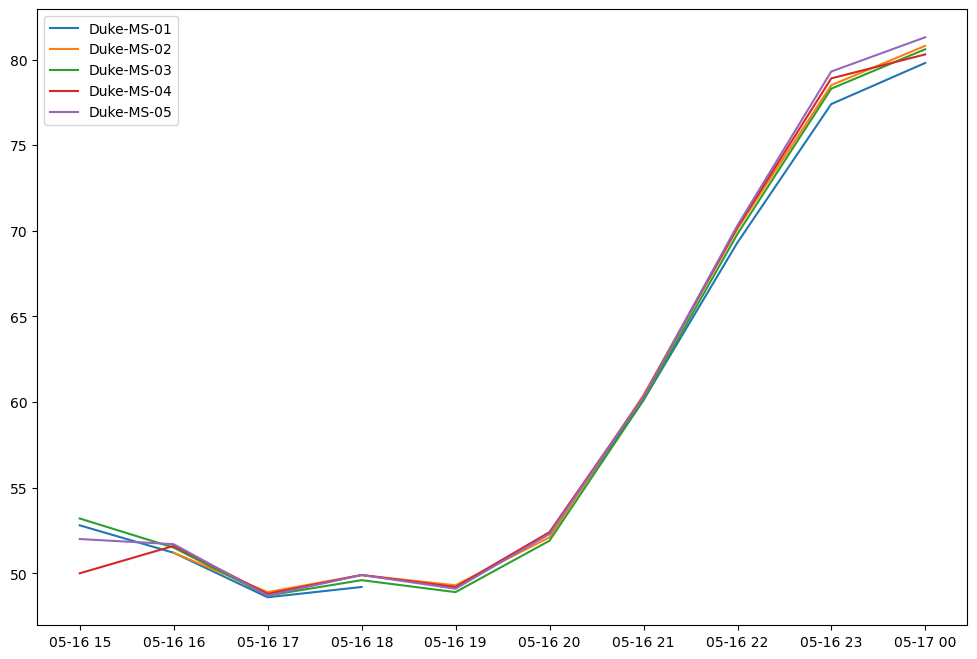

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12, 8))

for data, station in zip(all_data, stations):

    avg_temp = []
    time = []
    for observation in data.json()['observations']:
        avg_temp.append(observation['humidityAvg'])#['metric'][''])
        time.append(observation['obsTimeLocal'])


    # Change time to datetime list
    time = pd.to_datetime(time)

    plt.plot(time, avg_temp, label=station['name'])

plt.legend()
plt.show()

In [11]:
observation

{'stationID': 'KNCDURHA551',
 'tz': 'America/New_York',
 'obsTimeUtc': '2024-05-17T03:59:53Z',
 'obsTimeLocal': '2024-05-16 23:59:53',
 'epoch': 1715918393,
 'lat': 36.003,
 'lon': -78.938,
 'solarRadiationHigh': 0.0,
 'uvHigh': 0.0,
 'winddirAvg': 284,
 'humidityHigh': 83.0,
 'humidityLow': 80.0,
 'humidityAvg': 81.3,
 'qcStatus': 1,
 'metric': {'tempHigh': 20.8,
  'tempLow': 20.2,
  'tempAvg': 20.4,
  'windspeedHigh': 3.5,
  'windspeedLow': 0.0,
  'windspeedAvg': 0.5,
  'windgustHigh': 3.5,
  'windgustLow': 0.0,
  'windgustAvg': 0.5,
  'dewptHigh': 17.4,
  'dewptLow': 16.8,
  'dewptAvg': 17.0,
  'windchillHigh': 20.8,
  'windchillLow': 20.2,
  'windchillAvg': 20.4,
  'heatindexHigh': 20.8,
  'heatindexLow': 20.2,
  'heatindexAvg': 20.4,
  'pressureMax': 1014.22,
  'pressureMin': 1013.88,
  'pressureTrend': 0.0,
  'precipRate': 0.0,
  'precipTotal': 0.0}}